In [1]:
import pandas as pd
import os

In [2]:
images = os.listdir('/home/bharathraj/Documents/geoml-wd/data/google_maps_bj/img')

In [3]:
images[0]

'9.png'

In [4]:
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import matplotlib.patches as patches
import matplotlib.pyplot as plt

model = torch.load("/home/bharathraj/Documents/geoml-wd/models/bdappvFasterRCNN.pt", map_location=torch.device('cpu'))



def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')



def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes'].cpu()):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

def remove_low_score_boxes(prediction, threshold):
    boxes = prediction['boxes'][prediction['scores'] > threshold]
    scores = prediction['scores'][prediction['scores'] > threshold]
    labels = prediction['labels'][prediction['scores'] > threshold]
    
    prediction['boxes'] = boxes
    prediction['scores'] = scores
    prediction['labels'] = labels
    
    return prediction


def predict(image):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    img = torchtrans.ToTensor()(image)
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
    
    prediction = apply_nms(prediction, iou_thresh=0.3)
    prediction = remove_low_score_boxes(prediction, threshold=0.8)

    plot_img_bbox(image, prediction)
    return prediction



/home/bharathraj/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
images[0]

'9.png'

In [6]:
images.sort()
images[0]

'1.png'

In [7]:
# conver the YOLO format to the format to left x, top y, width, height format
import cv2

def convert_yolo_to_voc(image, label):
    img = cv2.imread('/home/bharathraj/Documents/geoml-wd/data/google_maps_bj/img/'+image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img.shape
    label = [float(i) for i in label]
    label[1] = label[1] * width
    label[2] = label[2] * height
    label[3] = label[3] * width
    label[4] = label[4] * height
    label[1] = label[1] - label[3]/2
    label[2] = label[2] - label[4]/2
    label[3] = label[1] + label[3]
    label[4] = label[2] + label[4]
    return label


In [8]:
# function to convert the bounding box labels to the format required by torchvision

def convert_bboxes_to_target(labels):
    boxes = []
    for label in labels:
        boxes.append([float(label[1]), float(label[2]), float(label[3]), float(label[4])])
    boxes = torch.tensor(boxes)
    labels = torch.tensor([int(label[0]) for label in labels])
    target = {}
    target['boxes'] = boxes
    target['labels'] = labels
    target['scores'] = torch.ones((len(labels),), dtype=torch.float32)
    return target

In [9]:
images

['1.png',
 '10.png',
 '2.png',
 '3.png',
 '4.png',
 '5.png',
 '6.png',
 '7.png',
 '8.png',
 '9.png']

In [10]:
images = []
for i in range(10):
    images.append(str(i+1)+'.png')

images

['1.png',
 '2.png',
 '3.png',
 '4.png',
 '5.png',
 '6.png',
 '7.png',
 '8.png',
 '9.png',
 '10.png']

In [11]:
labels_folder = '/home/bharathraj/Documents/geoml-wd/data/google_maps_bj/labels/'

labels = []

for image in images:
    with open(labels_folder+image.split('.')[0]+'.txt', 'r') as f:
        label = f.read()
        label = label.split('\n')
        label = [i.split(' ') for i in label]
        label = [convert_yolo_to_voc(image, i) for i in label]
        label = convert_bboxes_to_target(label)
        labels.append(label)


In [12]:
labels[0]

{'boxes': tensor([[377.8188, 282.9183, 464.6455, 340.4775]]),
 'labels': tensor([0]),
 'scores': tensor([1.])}

In [13]:
def predict(image):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    img = torchtrans.ToTensor()(image)
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
    
    prediction = apply_nms(prediction, iou_thresh=0.3)
    prediction = remove_low_score_boxes(prediction, threshold=0.8)

    return prediction


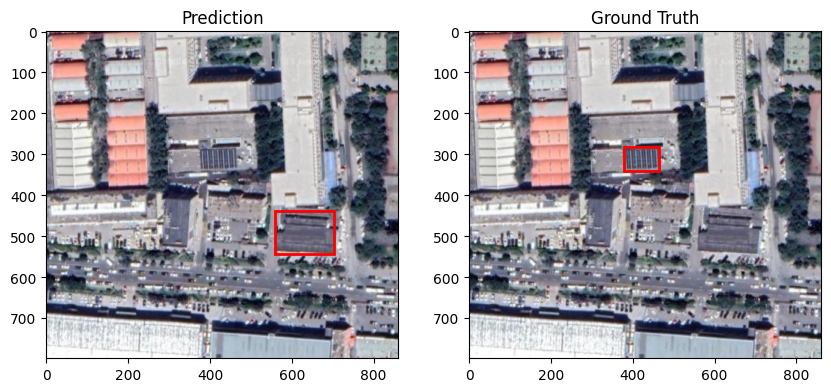

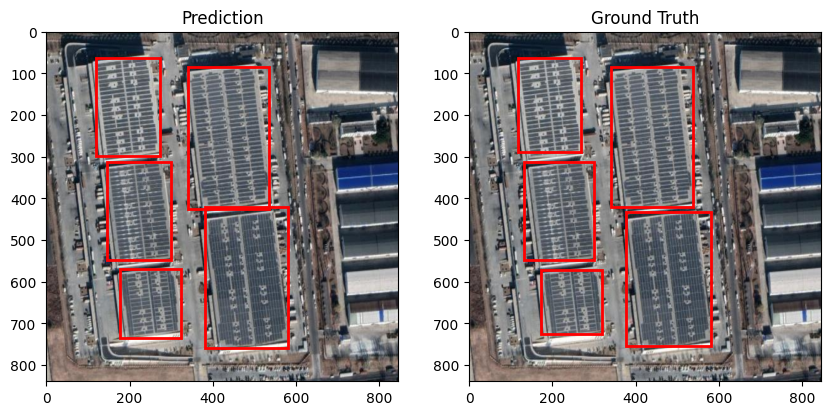

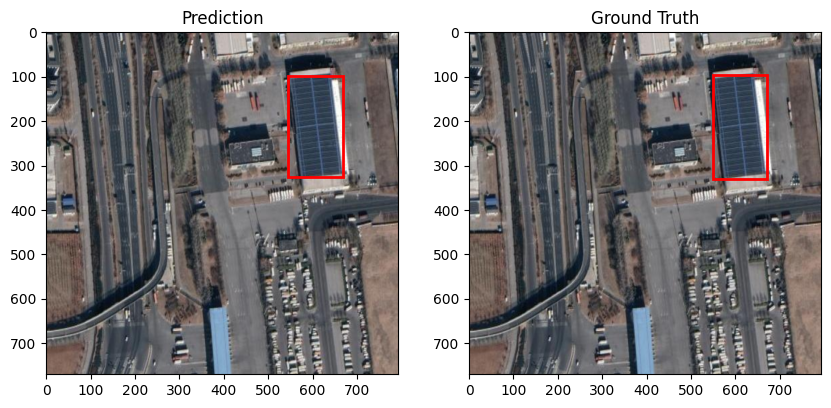

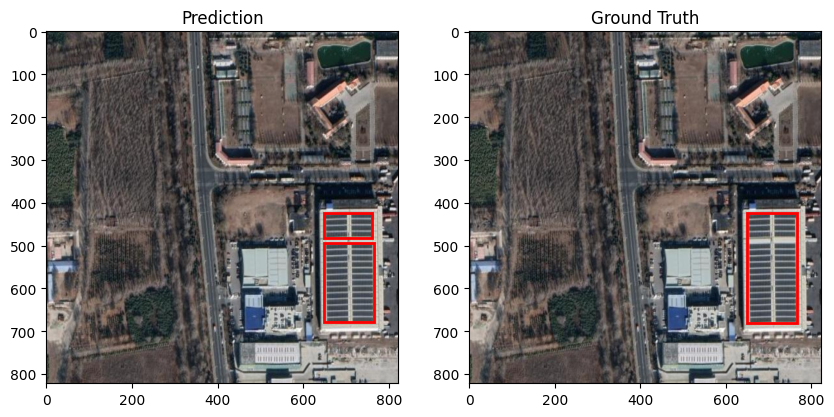

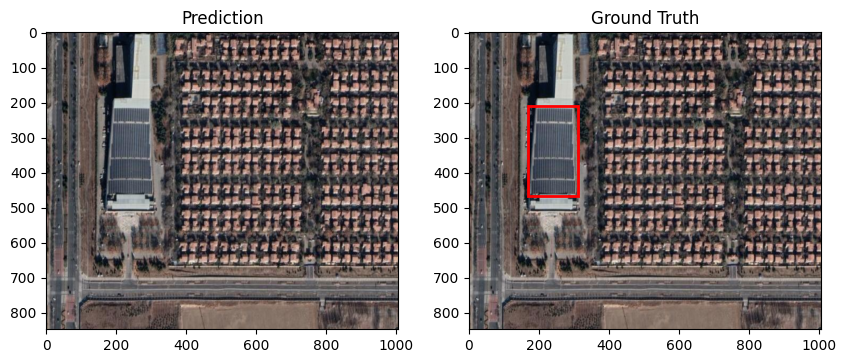

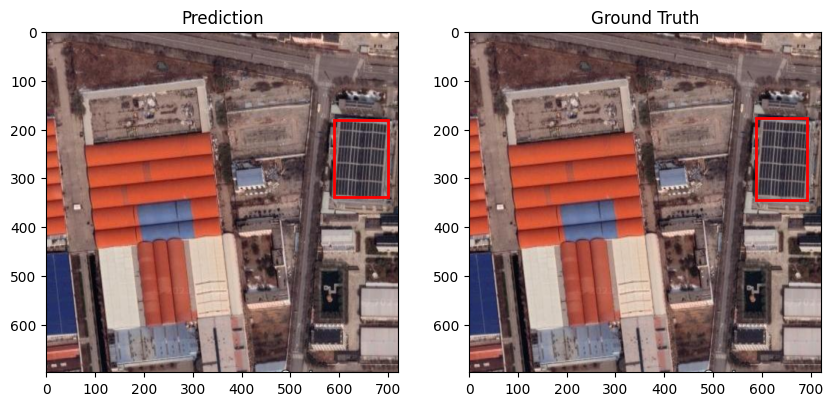

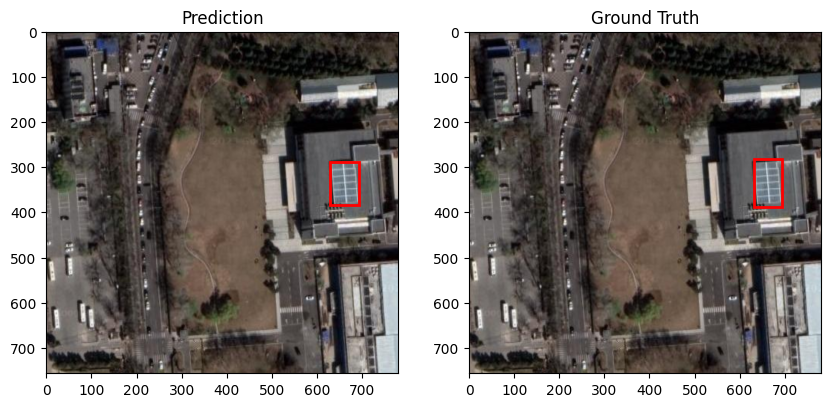

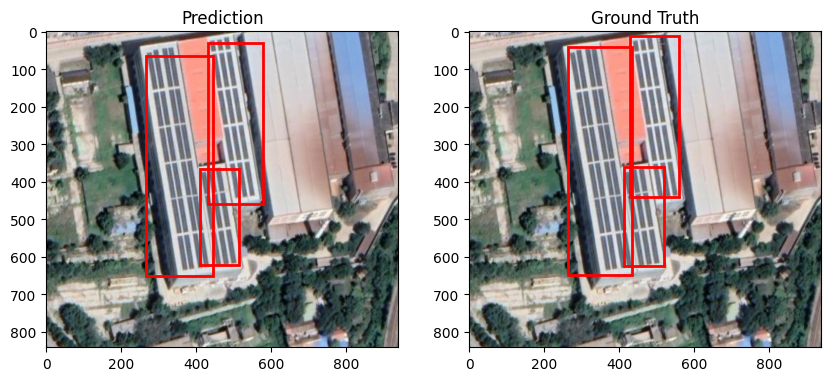

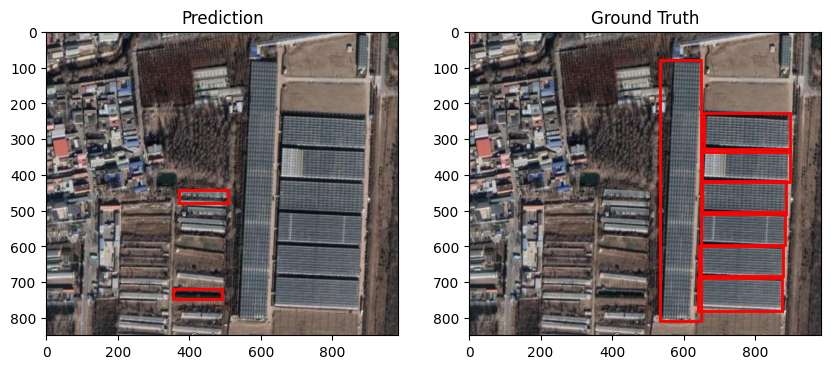

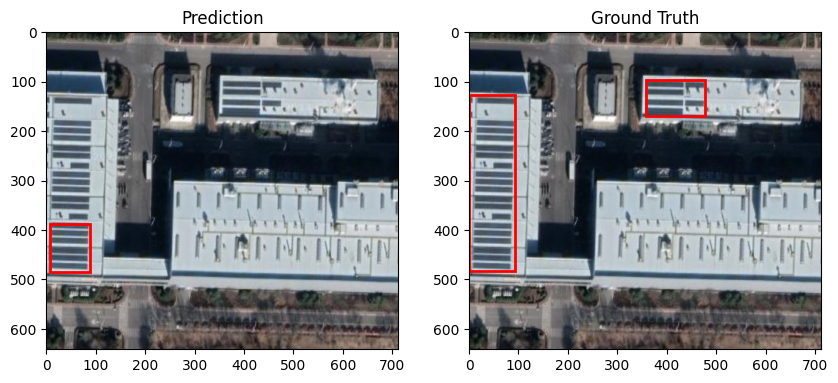

In [14]:
# plot image with predicted bounding boxes and ground truth bounding boxes side by side using plot_img_bbox

def plot_img_bbox_side_by_side(image, prediction, ground_truth):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].set_title('Prediction')
    ax[1].set_title('Ground Truth')
    ax[0].imshow(image)
    ax[1].imshow(image)
    for box in prediction['boxes']:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax[0].add_patch(rect)
    for box in ground_truth['boxes']:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)
    plt.show()


for i in images:
    img = cv2.imread('/home/bharathraj/Documents/geoml-wd/data/google_maps_bj/img/'+i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plot_img_bbox_side_by_side(img, predict(img), labels[int(i.split('.')[0])-1])

In [15]:
predictions = []

for i in images:
    img = cv2.imread('/home/bharathraj/Documents/geoml-wd/data/google_maps_bj/img/'+i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    predictions.append(predict(img))


In [16]:
# find each coordinate of a pixel covered by the bounding boxes of the predictions and ground truth

prediction_pixels = []
ground_truth_pixels = []

for i in range(len(predictions)):
    prediction_pixels.append([])
    ground_truth_pixels.append([])
    for box in predictions[i]['boxes']:
        xmin, ymin, xmax, ymax = box
        for x in range(int(xmin), int(xmax)+1):
            for y in range(int(ymin), int(ymax)+1):
                prediction_pixels[i].append((x, y))
    for box in labels[i]['boxes']:
        xmin, ymin, xmax, ymax = box
        for x in range(int(xmin), int(xmax)+1):
            for y in range(int(ymin), int(ymax)+1):
                ground_truth_pixels[i].append((x, y))

# compute the intersection over union for each image

iou = []

for i in range(len(prediction_pixels)):
    iou.append(len(set(prediction_pixels[i]).intersection(set(ground_truth_pixels[i])))/len(set(prediction_pixels[i]).union(set(ground_truth_pixels[i]))))

iou


[0.0,
 0.9359301207840515,
 0.9252213730177435,
 0.9208930899608866,
 0.0,
 0.8861024033437827,
 0.8847926267281107,
 0.8968755771382633,
 0.0,
 0.18227420829328894]

In [17]:
import statistics

results = {
    'average_iou': str(100*sum(iou)/len(iou))+ '%',
    'median_iou': str(100*statistics.median(iou))+ '%',
    'max': str(max(iou)*100)+ '%',
    'min': str(min(iou)*100)+ '%'
}
results

{'average_iou': '56.32089399266126%',
 'median_iou': '88.54475150359467%',
 'max': '93.59301207840515%',
 'min': '0.0%'}